In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt 

from graphviz import Digraph

from micrograd.engine import Value

%matplotlib inline

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

In [2]:
# a function that takes a single scaler of x and returns a single scaler of y
# a quadratic function - parabola shape
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

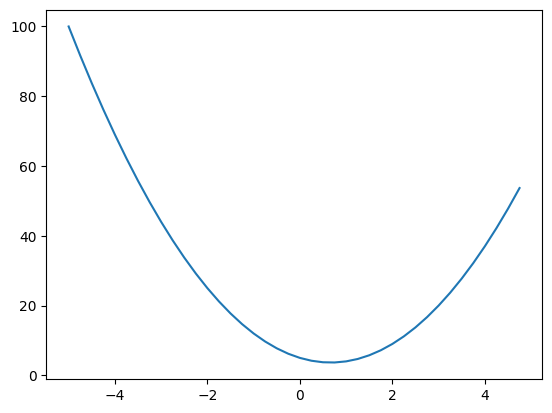

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)
# plt.grid()

In [5]:
# https://en.wikipedia.org/wiki/Derivative
h = 0.000001
x = 2/3
 
# the slope = function response / run = rise / run
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# more complex - derivative of a function with multiple scalar inputs
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs in which we would evaluate the derivative of d wrt to each of them
a = 2.0
b = -3.0
c = 10.0
 
d1 = a*b + c

# finding the derivative of d wrt b
b += h # pumping b with h 
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [8]:
# Value is a data structure to maintaie the large mathematical expressions of nn
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
# (a._add(b)).__add(c) internally called
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [9]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [10]:
L._op

'*'

#### Trace graph Value structure

In [11]:
def trace(root):
    nodes, edges = set(), set()
    # builds a set of all nodes and edges in a graph
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a resolt of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op nde of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

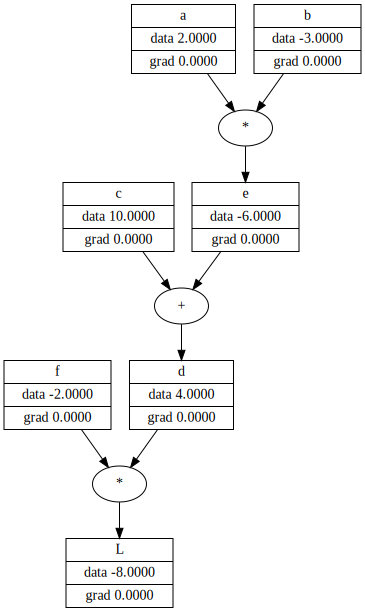

In [12]:
# visualising the forward pass
draw_dot(L, rankdir='TB')

#### manually backpropagation

The derivative of L with respect to d ..

L = d * f \
dL/dd = ? -> f

By definition of derivative, dL/dd .. \
= (f(x + h) - f(x))/h  \
= (d+h) * f - d * f)/h \
= (d*f + h+f - d*f)/h \
= h*f / h \
= f

----

The derivative of L with respect to c \
dL / dc = ? \
dd / dc = ? -> 1.0 (intermediate result of the chain rule of dL / dc, bcs d = c+e, and the deriv is equal to 1)

d = c + e \

By definition of derivative, dd / dc  .. \
= (f(x+h) - f(x))/h  \
= ((c+h)+e - (c+e))/h  \
= (c+h+e-c-e)/h  \
= h / h = 1.0 

Thus dd / de will also be 1.0

To find dL / dc, we use calculus chain rule! \
dL / dc = (dL / dd) * (dd / dc) \
dL / dc = f * 1.0 = f = -2.0 
dL / dc = = dL / de = -2.0

Thus, the plus node routes the derivative to both c and e 

----
Finding dL / da .. \
dL / da = (dL / de) * (de / da) = -2.0 * (de / da) 

e = a + b, what is de / da? -> -3

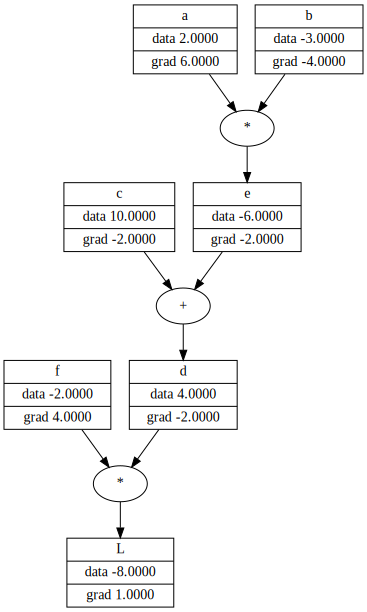

In [13]:
# manually backpropagation
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L, rankdir='TB')

In [14]:
def fx():
    h=0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
fx()

-3.9999999999995595


In [15]:
# preview of a single optimization step
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# expect L to go up (positive)
# re-running the forward pass calculation
e = a * b;
d = e + c;
L = d * f;

print(L.data)

-7.286496


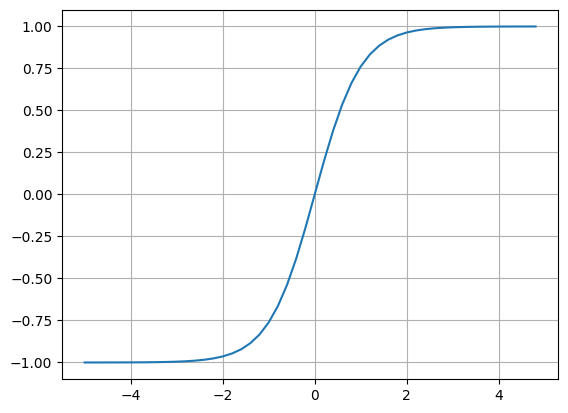

In [16]:
# visualising the tanh activation function of the nn
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

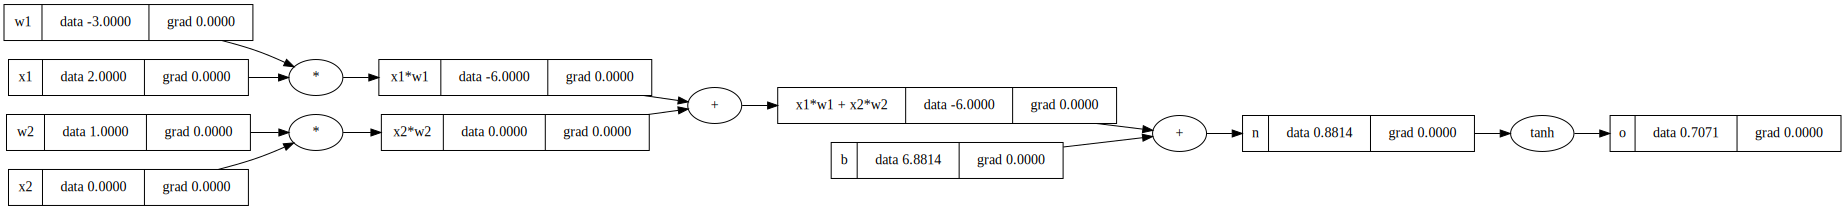

In [17]:
# Neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# n is the cell body without the activation
n = x1w1x2w2 + b; n.label = 'n'

# using the activation function
o = n.tanh(); o.label = 'o'

draw_dot(o, rankdir='LR')

In [18]:
# # backprop manually again 
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = ? --> = 1 - tanh(n)^2 = 1 - o^2
# n.grad = 1 - o.data**2 # 0.5

# # the gradient flows to the previous nodes as a result of the sum '+'
# x1w1x2w2.grad = 0.5
# b.grad = 0.5

# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# draw_dot(o, rankdir='LR')

In [19]:
# backpropagation with the method implemented
# o.grad = 1.0

# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

# draw_dot(o, rankdir='LR')

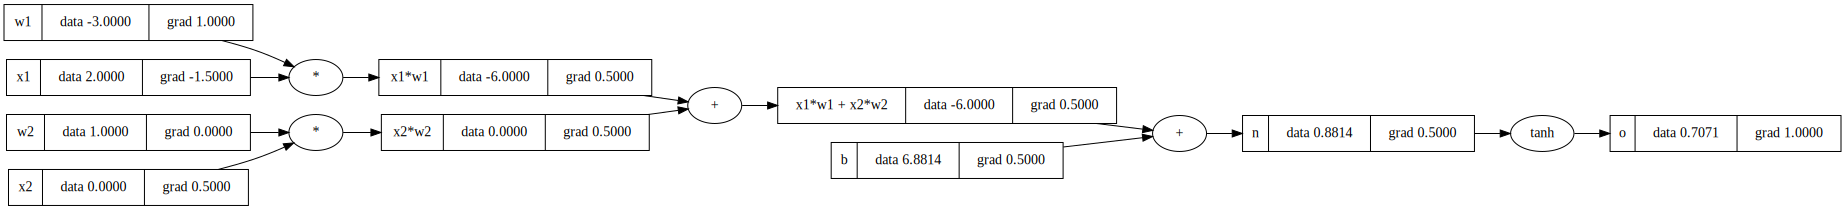

In [20]:
# using the topological graph implemented
o.backward()
    
draw_dot(o, rankdir='LR')

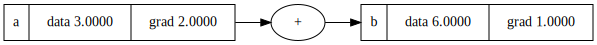

In [21]:
a = Value(3.0, label = 'a')
b = a + a     ; b.label = 'b'

b.backward()
draw_dot(b)

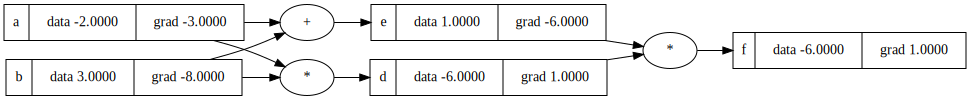

In [22]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b     ; d.label = 'd'
e = a + b     ; e.label = 'e'
f = d * e     ; f.label = 'f'

f.backward()
draw_dot(f)

In [23]:
# Improving Value holder to handle other cases
a = Value(2.0)
a = a + 1
a

Value(data=3.0)

In [24]:
a * 2

Value(data=6.0)

In [25]:
# __rmul__ callback handles this order of multiplication 2.__mul__(a)
2 * a

Value(data=6.0)

In [26]:
a = Value(2.0)
b = Value(4.0)
a.exp()

Value(data=7.38905609893065)

In [27]:
a / b
# a * (1/b)
a * b**-1

Value(data=0.5)

In [28]:
a - b

Value(data=-2.0)

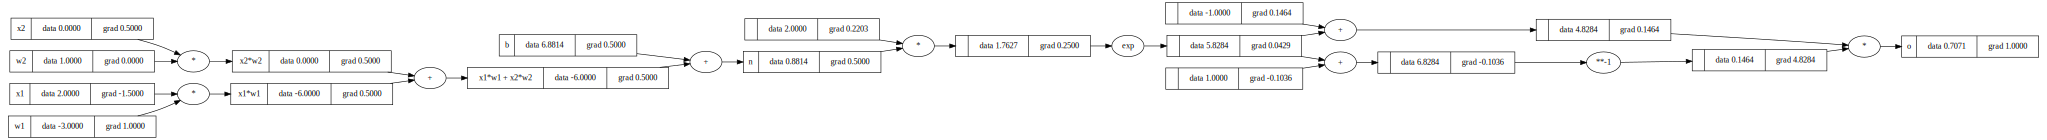

In [29]:
# modifying the activation function tanh

# Neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# n is the cell body without the activation
n = x1w1x2w2 + b; n.label = 'n'

# using the activation function
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o, rankdir='LR')

In [30]:
# implementing using pytorch
import torch

In [31]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [32]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n  = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2 ', x2.grad.item())
print('w2 ', w2.grad.item())
print('x1 ', x1.grad.item())
print('w1 ', w1.grad.item())

0.7071066904050358
---
x2  0.5000001283844369
w2  0.0
x1  -1.5000003851533106
w1  1.0000002567688737


In [33]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [63]:
# implementing Neuron
from micrograd.nn import Neuron, Layer, MLP

In [64]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9301527054051346)

In [65]:
x = [2.0, 3.0]
n = Layer(2, 3) # 2D neurons, 3 of them
n(x)

[Value(data=0.9930882511356333),
 Value(data=0.8268322174639375),
 Value(data=-0.9166921434904977)]

In [68]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6554285370434155)

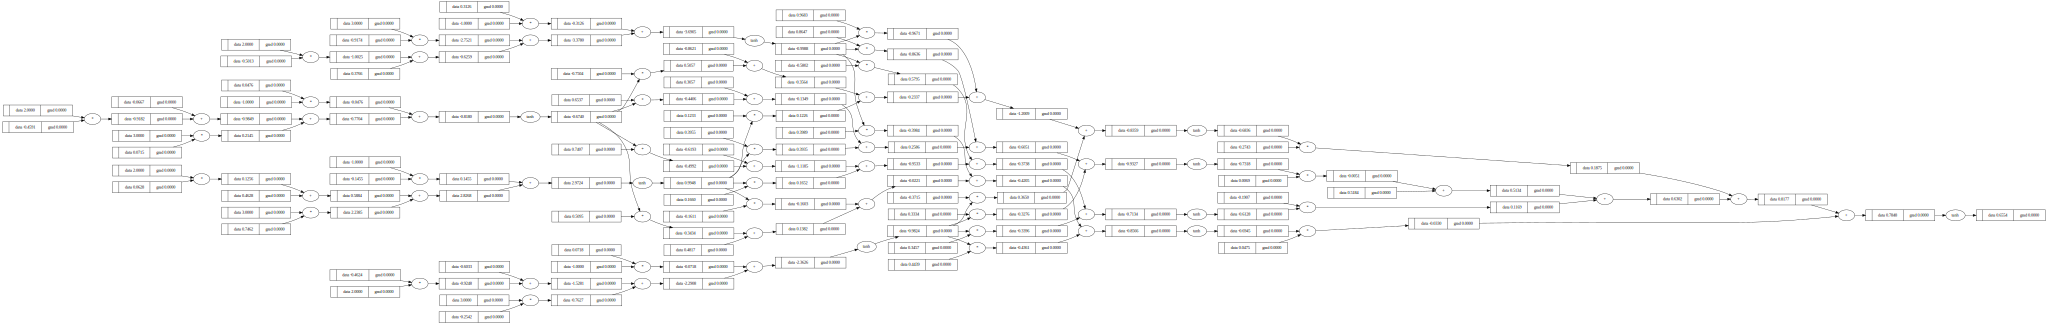

In [70]:
draw_dot(n(x))

In [76]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=0.6554285370434155),
 Value(data=0.570101903101852),
 Value(data=0.6583621566468192),
 Value(data=0.6590791069195824)]

In [78]:
# mse loss
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.450341577145138)

In [79]:
loss.backward()

In [83]:
n.layers[0].neurons[0].w[0].grad

0.2641125891803143

In [89]:
# dot = draw_dot(loss, rankdir='TB')

# # Render and save the graph to a file named "graph_output.svg"
# output_file = r"graphs/graph_output"
# dot.render(filename=output_file, view=False)

'graphs/graph_output.svg'